# Conditional VAE

With Input:
- Image Label
- Coordinate

In [1]:
import os
import csv
import numpy as np
import math
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from skimage import io
from PIL import Image
from tqdm import tqdm
#import argparse

import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.utils import save_image

matplotlib.style.use('ggplot')

torch.cuda.empty_cache() 
#import model

import ast

## To load in the dataset

In [2]:
class ActiveVisionDataset (Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.annotations = pd.read_csv(csv_file, index_col=None)
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self,index):
        if type(index) == torch.Tensor:
            index = index.item()
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = io.imread(img_path)
        #image = image/(image.max()/255.0)
        shape_label = torch.tensor(int(self.annotations.iloc[index,1]))
        #print(shape_label)
        cam_loc = torch.tensor(ast.literal_eval(self.annotations.iloc[index,2]))
#         print(cam_loc)
        cam_loc = torch.tensor([cam_loc[1]/(2*math.pi), cam_loc[2]/math.pi])
#         print(cam_loc)
        if self.transform:
            image = self.transform(image)
        
        return image, shape_label, cam_loc

## Encoder

In [3]:
class Encoder(nn.Module):
    def __init__(self, z_dim):
        super(Encoder, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=init_filters, kernel_size=kernel_size, stride=stride, padding=padding
        )
        self.conv2 = nn.Conv2d(
            in_channels=init_filters, out_channels=init_filters, kernel_size=kernel_size, stride=stride, padding=padding
        )
        self.conv3 = nn.Conv2d(
            in_channels=init_filters, out_channels=init_filters, kernel_size=kernel_size, stride=stride, padding=padding
        )
        self.conv4 = nn.Conv2d(
            in_channels=init_filters, out_channels=init_filters, kernel_size=kernel_size, stride=stride, padding=padding
        )
        self.conv5 = nn.Conv2d(
            in_channels=init_filters, out_channels=init_filters, kernel_size=kernel_size, stride=stride, padding=padding
        )

        self.img_lin1 = nn.Linear(init_filters*(conv_out_size**2), 1024)
        self.img_lin2 = nn.Linear(4096, 1024)
        
        self.label_lin1 = nn.Linear(6,16)
        
        self.coord_lin1 = nn.Linear(3,16)
        
        self.comb_lin1 = nn.Linear(1024+2,256)
        self.comb_lin2 = nn.Linear(512,256)

        self.mu = nn.Linear(256, z_dim)
        self.sigma = nn.Linear(256, z_dim)
        
        self.dropout = nn.Dropout(p=dropout_pcent)
        
        self.dropout_label = nn.Dropout(p=label_dropout_pcent)
        
        self.bn1 = nn.BatchNorm1d(1024+2)
        self.bn2 = nn.BatchNorm1d(256)
        
    def forward(self, image, label, coord):
        
        #Image                                                                 #print("before anything") #print(image.shape)
        x = self.conv1(image)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = F.relu(x)
        
        #print("before flatten:" + str(x.shape))
        x = x.view(x.size(0), -1)
        #print("after flatten:" + str(x.shape))

        x = self.img_lin1(x)
        x = self.dropout(x)
        x = F.relu(x)
#         x = self.img_lin2(x)
#         x = F.relu(x)
        
        #Label                                                  #label = torch.unsqueeze(label, dim=1)
        label = F.one_hot(label, num_classes=6)
        label = label.type(torch.FloatTensor).to(device)
        
        label = self.dropout_label(label)
        
        #coord = self.dropout_label(coord)
        
        y = torch.cat([label, coord], dim=1)
        y = self.dropout_label(y)
        
        
        #Concatenation
        concat = torch.cat([x,coord],dim=1)
        #x = torch.cat([x,y],dim=1)
                                                                               #print(label) print(label.shape) print(coord) 
                                                                 #print(coord.shape) print(y) print(y.shape) #print(x.shape)
        
#         x = self.dropout(concat) if reintroduced change line below to x
        #print("after combination:" + str(x.shape))
#         x = self.bn1(concat)
        x = self.comb_lin1(concat)
        x = F.relu(x)
        
        # get `mu` and `log_var`
        mu = self.mu(x)
        log_var = self.sigma(x)
        
        return mu, log_var

## Decoder

In [4]:
class Decoder(nn.Module):
    def __init__(self, z_dim):
        super(Decoder, self).__init__()
        
#         self.img_lin1 = nn.Linear(z_dim, 256)
        
#         self.label_lin1 = nn.Linear(6,16)
        
#         self.coord_lin1 = nn.Linear(3,16)
        
        self.comb_lin1 = nn.Linear(z_dim+2, 1024)
        self.comb_lin2 = nn.Linear(1024, init_filters*(conv_out_size**2))
        
        
        self.dec1 = nn.ConvTranspose2d(
            in_channels=init_filters, out_channels=init_filters, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=1
        )
        self.dec2 = nn.ConvTranspose2d(
            in_channels=init_filters, out_channels=init_filters, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=1
        )
        self.dec3 = nn.ConvTranspose2d(
            in_channels=init_filters, out_channels=init_filters, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=1
        )
        self.dec4 = nn.ConvTranspose2d(
            in_channels=init_filters, out_channels=init_filters, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=1
        )
        self.dec5 = nn.ConvTranspose2d(
            in_channels=init_filters, out_channels=3, kernel_size=kernel_size, stride=stride, padding=padding, output_padding=1
        )
        
        self.dropout = nn.Dropout(p=dropout_pcent)
        
        self.dropout_label = nn.Dropout(p=label_dropout_pcent)
        
    def forward(self, x, label, coord):
        
        #Latent Vector
#         x = self.img_lin1(z)
#         x = F.relu(x)
#         x = self.dropout(x)
        
        #Label
        label = F.one_hot(label, num_classes=6)
        label = label.type(torch.FloatTensor).to(device)
        
        label = self.dropout_label(label)
        #coord = self.dropout_label(coord)
        
        y = torch.cat([label, coord], dim=1)
        y = self.dropout_label(y)
        
        
        #Concatenation
        concat = torch.cat([x,coord],dim=1)
        #x = torch.cat([x,y],dim=1)
        
#         x = self.dropout(concat) if reintroduced change line below to x
        x = self.comb_lin1(concat)
        x = F.relu(x)
        x = self.comb_lin2(x)
        x = F.relu(x)
        
        x=x.view(-1, init_filters, conv_out_size, conv_out_size)
        #print("after unflatten:")
        #print(x.shape)
        
        x = self.dec1(x)
        x = F.relu(x)
        x = self.dec2(x)
        x = F.relu(x)
        x = self.dec3(x)
        x = F.relu(x)
        x = self.dec4(x)
        x = F.relu(x)
        x = self.dec5(x)
        reconstruction = torch.sigmoid(x)
        
        return reconstruction

## VAE

In [5]:
class ConditionalVAE(nn.Module):
    def __init__(self, z_dim):
        super(ConditionalVAE, self).__init__()
        self.encoder = Encoder(z_dim)
        self.decoder = Decoder(z_dim)
    
    def forward(self, image, label, coord):
        mu, log_var = self.encoder(image, label, coord)
        
        #print('mu: ', mu.shape)
        #print('log_var: ', log_var.shape)
        
        #sample z from latent distribution q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu,std)
        z = q.rsample()
        #print('z shape: ', z.shape)
        
        reconstruction = self.decoder(z, label, coord)
                
        return reconstruction, mu, log_var, z

## Loss Helper Functions

In [6]:
def gaussian_likelihood(mean, logscale, sample):
    scale = torch.exp(logscale)
    dist = torch.distributions.Normal(mean, scale)
    log_pxz = dist.log_prob(sample)
    return log_pxz.sum(dim=(1, 2, 3))

def kl_divergence(z, mu, std):
    # --------------------------
    # Monte carlo KL divergence
    # --------------------------
    # 1. define the first two probabilities (in this case Normal for both)
    p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
    q = torch.distributions.Normal(mu, std)

    # 2. get the probabilities from the equation
    log_qzx = q.log_prob(z)
    log_pz = p.log_prob(z)

    # kl
    kl = (log_qzx - log_pz)
    kl = kl.sum(-1)
    return kl

## Training

In [7]:
def fit(model, dataloader):
    model.train()
    torch.set_grad_enabled(True)
    running_loss = 0.0
    
    for batch in tqdm(dataloader):
        image, label, coord = batch
        #print(image.size())
        #print(label)
        if torch.cuda.is_available():
            image = image.to(device)
            label = label.to(device)
            coord = coord.to(device)
        optimizer.zero_grad()
        
        reconstruction, mu, log_var, z = model(image, label, coord)
        
        #print(reconstruction.shape)
        
        #image = image.to(torch.device('cpu'))
#         recon_loss = gaussian_likelihood(reconstruction, log_scale, image)
        recon_loss = loss(reconstruction, image)
        
        std = torch.exp(log_var / 2)
        kl = kl_divergence(z, mu, std)
        
#         print("Training:")
#         print("kl:" + str(kl))
#         print("recon:"+ str(recon_loss))

        elbo = (beta*kl + recon_loss)
        elbo = elbo.mean()
        
        elbo.backward()
        optimizer.step()
        
        running_loss += elbo
    
    train_loss = running_loss/len(dataloader.dataset) #Investigate
    return train_loss

## Validation

In [8]:
def validate(model, dataloader, epoch, object_relevant_z):
    model.eval()
    running_loss_true = 0.0
    running_loss_noisy = 0.0
    i = 0
    with torch.no_grad():
        for batch in tqdm(dataloader):
            
            image, label, coord = batch
            
#             noisy_z = torch.empty(batch_size, latent_dim).normal_(mean=0,std=1.0)
            
            noisy_z = []
            for j in range (0, batch_size):
                noisy_z.append(object_relevant_z[label[j].item()])
#             noisy_z = torch.tensor(noisy_z).normal_(mean=0,std=1.0)
            noisy_z = torch.tensor(noisy_z)
                
            if torch.cuda.is_available():
                image = image.to(device)
                label = label.to(device)
                coord = coord.to(device)
                noisy_z = noisy_z.to(device)
            
            reconstruction_true, mu, log_var, z = model(image, label, coord)
            
            #print("Real Vector:" + str(z.shape))
            #print("Imitation Vector:" + str(noisy_z.shape))
            
            reconstruction_noisy = model.decoder(noisy_z, label, coord)
            
            if (i == int(len(val_data)/dataloader.batch_size) - 1 and ( ((epoch%val_img_out_freq))==4) ): # or epoch > 90
                num_rows = 4
                both = torch.cat((image.view(batch_size, 3, image_size, image_size)[:4], 
                                  reconstruction_true.view(batch_size, 3, image_size, image_size)[:4],
                                  reconstruction_noisy.view(batch_size, 3, image_size, image_size)[:4]))
                save_image(both.cpu(), f"outputs/{parameter}{value}/imgs/output{epoch}.png", nrow=num_rows)
            
#             recon_loss = gaussian_likelihood(reconstruction, log_scale, image)
            recon_loss_true = loss(reconstruction_true, image)
            recon_loss_noisy = loss(reconstruction_noisy, image)
        
            std = torch.exp(log_var / 2)
            kl = kl_divergence(z, mu, std)
            
#             print("Validation:")
#             print("kl:" + str(kl))
#             print("recon:"+ str(recon_loss))

            elbo_true = (beta*kl + recon_loss_true)
            elbo_true = elbo_true.mean()
        
            elbo_noisy = (beta*kl + recon_loss_noisy)
            elbo_noisy = elbo_noisy.mean()
            
            running_loss_true += elbo_true
            
            running_loss_noisy += elbo_noisy
            
            i+=1
    
    val_loss_true = running_loss_true/len(dataloader.dataset)
    val_loss_noisy = running_loss_noisy/len(dataloader.dataset)
    return val_loss_true, val_loss_noisy

In [9]:
def generate_latent_vectors(model, dataloader):
    model.eval()
    latent = []
    target = []
    with torch.no_grad():
        for batch in tqdm(dataloader):
            image, label, coord = batch
            #if torch.cuda.is_available():
            #    data = data.to(device)
            mu, logvar = model.encoder(image.cuda(), label.cuda(), coord.cuda())
            latent.extend(mu.cpu().detach().numpy())
            target.extend(label.numpy())
#         print(len(latent))
#         print(latent)
#         print(len(target))
#         print(target)
        return latent, target

## Run

In [10]:
def step_decay(epoch):
    drop = 0.5
    epochs_drop = 25.0
    lrate = initial_learning_rate * math.pow(drop,math.floor((1+epoch)/epochs_drop))
    return lrate

In [11]:
from IPython.display import clear_output
from time import sleep
def run_each():
    train_loss = []
    val_loss_true = []
    val_loss_noisy = []
    for epoch in range(epochs):
        clear_output(wait=True)
        print(f"Epoch {epoch+1} of {epochs}")
        sleep(0.2)
        train_epoch_loss = fit(model, train_loader)
        
        latent, target = generate_latent_vectors(model, val_loader)
        unique = set(target)
        unique = list(unique)
        object_relevant_z= dict()
        
        df = pd.DataFrame(list(zip(latent, target)), columns =['vector', 'object_type'])
        for obj_type in unique:
            object_relevant_z[obj_type] = df.loc[df['object_type'] == obj_type, 'vector'].mean()
        
        val_epoch_loss_true, val_epoch_loss_noisy = validate(model, val_loader, epoch, object_relevant_z)

        train_loss.append(train_epoch_loss)
        val_loss_true.append(val_epoch_loss_true)
        val_loss_noisy.append(val_epoch_loss_noisy)
        
        learning_rate = step_decay(epoch)
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

#         print(f"Train Loss: {train_epoch_loss:.4f}")
#         print(f"Val Loss: {val_epoch_loss:.4f}")
    return train_loss, val_loss_true, val_loss_noisy

In [12]:
def runall():
    train_loss, val_loss_true, val_loss_noisy = run_each()
    plt.figure(figsize=(10,10))
    plt.plot(range(1,epochs+1), train_loss, label="Train Loss")
    plt.plot(range(1,epochs+1), val_loss_true, label="Validation Loss (True Reconstruction)")
    plt.plot(range(1,epochs+1), val_loss_noisy, label="Validation Loss (Noisy Reconstruction)")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    axes = plt.gca()
    
    latent, target = generate_latent_vectors(model, val_loader)
    
    with open('outputs/'+parameter+value+'/sample_latent_vectors'+parameter+value+'.csv','w', newline='') as f:
        wr = csv.writer(f)
        wr.writerow(["Latent", "Target"])
        
        for i in range (0,len(latent)):
            latent[i] = list(latent[i])
            
        wr.writerows(zip(latent, target))
    
    filepath = os.path.join(os.getcwd(), "outputs", parameter+str(value), parameter+str(value)+".pth")
    torch.save(model.state_dict(), filepath)
    
    plt.savefig('outputs/'+parameter+value+'/loss'+parameter+value+'.png')
    
    with open('outputs/'+parameter+value+'/loss'+parameter+value+'.csv','w', newline='') as f:
        wr = csv.writer(f)
        wr.writerow(["Train loss", "Val loss"])
        
        for i in range (0,len(train_loss)):
            train_loss[i] = train_loss[i].item()
        
        for i in range (0,len(val_loss_true)):
            val_loss_true[i] = val_loss_true[i].item()
        
        for i in range (0,len(val_loss_noisy)):
            val_loss_noisy[i] = val_loss_noisy[i].item()
            
        wr.writerows(zip(train_loss, val_loss_true, val_loss_noisy))
        
    with open('outputs/lossCompare.csv', 'a+', newline='') as f:
        wr = csv.writer(f)
        wr.writerow([parameter,
                     value,
                     train_loss[-1],
                     val_loss_true[-1],
                     val_loss_noisy[-1],
                     enc_out_dim, 
                     latent_dim, 
                     epochs,
                     batch_size, 
                     initial_learning_rate, 
                     kernel_size, 
                     stride,
                     padding, 
                     init_filters,
                     dropout_pcent,
                    ])

### Parameters

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

param_dict = {
    
    "enc_out_dim": 512,
    "latent_dim": 128,
    "conv_out_size": 4,
    
    "epochs" : 50,
    "batch_size" : 8,
    "initial_learning_rate" : 0.001,
    
    "kernel_size" : 5,
    "stride" : 2,
    "padding" : 2,
    
    "init_filters" : 128,
    
    "dropout_pcent": 0.0,
    "image_size": 128,
    
    "label_dropout_pcent": 1.0
    
}

cuda


Epoch 50 of 50


100%|██████████████████████████████████████████████████████████████████████████████████| 75/75 [00:00<00:00, 99.14it/s]


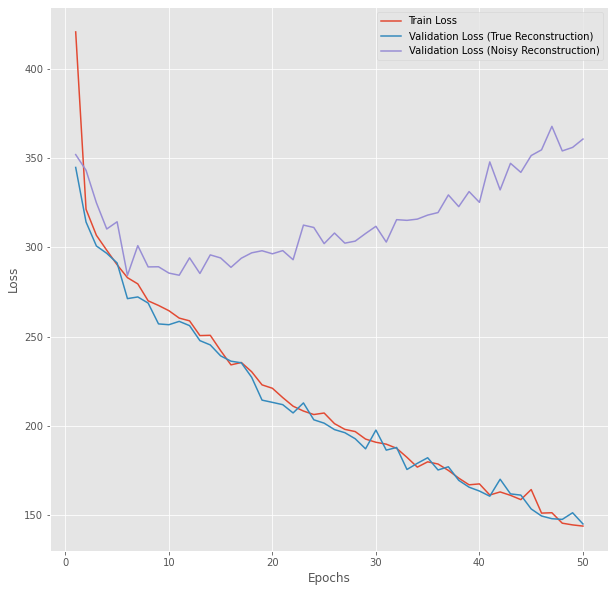

In [14]:
val_img_out_freq = 5
parameter_list = ['ImageDropout']
value_list = [0]

for parameter in parameter_list:
    for value in value_list:
        #Update the values to be updated and rerun the experiment
        enc_out_dim = param_dict["enc_out_dim"]
        latent_dim = param_dict["latent_dim"]
        conv_out_size = param_dict["conv_out_size"]

        epochs = param_dict["epochs"]
        batch_size = param_dict["batch_size"]
        initial_learning_rate = param_dict["initial_learning_rate"]

        kernel_size = param_dict["kernel_size"]
        stride = param_dict["stride"]
        padding = param_dict["padding"]
        init_filters = param_dict["init_filters"]
        
        dropout_pcent = param_dict["dropout_pcent"]
        image_size = param_dict["image_size"]
        
        label_dropout_pcent = param_dict["label_dropout_pcent"]
        
        beta = 1
        
        #Move batch_size to before so its trained on the same split?
        set_used = 'datasets/SmallGrey'
        train_data = ActiveVisionDataset(csv_file=set_used+'/TrainSet/rgbCSV.csv', root_dir=set_used+'/TrainSet/segImg/', transform = torchvision.transforms.ToTensor())
        val_data = ActiveVisionDataset(csv_file=set_used+'/ValSet/rgbCSV.csv', root_dir= set_used+'/ValSet/segImg/', transform = torchvision.transforms.ToTensor())
        train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(dataset=val_data, batch_size=batch_size, shuffle=True)

        img_size = len(train_data[0][0][0])
        model = ConditionalVAE(latent_dim).to(device)
        optimizer = optim.Adam(model.parameters(), lr=initial_learning_rate)

        log_scale = nn.Parameter(torch.Tensor([0.0])).to(device)
        loss = nn.MSELoss(reduction = 'sum')
        
        
        #Change the value to a string for later
        value = str(value)
        os.makedirs("outputs/"+parameter+str(value), exist_ok=True)
        os.makedirs("outputs/"+parameter+str(value)+"/imgs", exist_ok=True)
        
        #Run the Test
        runall()